# Sketch Classifier for "How Do Humans Sketch Objects?"

A sketch classifier using the dataset from the paper <a href='http://cybertron.cg.tu-berlin.de/eitz/projects/classifysketch/'>How Do Humans Sketch Objects?</a> where the authors collected 20,000 unique sketches evenly distributed over 250 object categories - we will use a CNN (using Keras) to classify a sketch. 

<img src='http://cybertron.cg.tu-berlin.de/eitz/projects/classifysketch/teaser_siggraph.jpg'/>

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import imresize
import os
import random 

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.style.use('ggplot')

In [3]:
import keras 
keras.__version__

Using TensorFlow backend.


'2.0.8'

In [76]:
from keras import layers
from keras import models
from keras import optimizers
from keras import callbacks
from keras import Input

from keras.utils import plot_model

from keras import backend as K

from keras import preprocessing
from keras.preprocessing import image

## Trained on Floydhub

In [5]:
DEST_SKETCH_DIR = '/Users/Joshua.Newnham/Dropbox/Method - Personal/Machine Learning with CoreML/TrainingData/Chapter8/sketches/'
TARGET_SIZE = (256,256)
CATEGORIES_COUNT = 205
TRAINING_SAMPLES = 12736
VALIDATION_SAMPLES = 3184

## Create model 

More data always proves to be useful; exposing the network to more samples means that the model has a better chance of identifying and extracting the features that best *describe* a category. Images provide has an advantage over text in that we can easily modify it to expose the network to more samples, such as shifting the image around, rotating and flipping. This task is called *data augmentation* and Keras makes it easy, as shown below. For more information, check out the official Keras <a href='https://keras.io/preprocessing/image/'>documentation</a>. 

Inutitive we can see that, unlike photos, sketches don't have mine details but are better described by their strokes. This is how I had previously tackled the problem; using <a href='https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients'>Histogram of oriented gradients (HOG)</a> filters, I built a bag of visual words for each image. These 'visual words' were dominate gradients of each patch. We can replicate something similar using a ConvNet, but unlike my previous attempt, the feature engineering will be defined and refined during training using the lower layers of the network. 

In [6]:
def create_model(input_shape=(256,256,1), classes=CATEGORIES_COUNT, is_training=True):
    """
    Create a CNN model 
    """
    
    model = models.Sequential() 
    model.add(layers.Conv2D(16, kernel_size=(7,7), strides=(3,3),  
                            padding='same', activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D(2,2))    
    
    model.add(layers.Conv2D(32, kernel_size=(5,5), padding='same', activation='relu'))        
    model.add(layers.MaxPooling2D(2,2))    
    
    model.add(layers.Conv2D(64, (5,5), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(2,2))    
    if is_training:
        model.add(layers.Dropout(0.125))
    
    model.add(layers.Conv2D(128, (5,5), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(2,2))    
    
    model.add(layers.Flatten())                
    model.add(layers.Dense(512, activation='relu', name='dense_2_512'))
    if is_training:
        model.add(layers.Dropout(0.5))
        
    model.add(layers.Dense(classes, activation='softmax', name='output'))
    
    return model

In [10]:
model = create_model() 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 86, 86, 16)        800       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 43, 43, 32)        12832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 64)        51264     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 10, 64)        0         
__________

--- 

## Load (pretrained) model 

In [12]:
model = create_model() 
model.load_weights("output/cnn_sketch_weights_2.h5")

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 86, 86, 16)        800       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 43, 43, 16)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 43, 43, 32)        12832     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 21, 21, 64)        51264     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 10, 10, 64)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 10, 10, 64)        0         
__________

In [14]:
def get_validation_metadata():
    """
    Walk the root directory and for each subdirectory, obtain the 
    list of .png image files creating (and returning) a list for each category label and 
    associated filepath 
    """
    image_file_paths = [] 
    categories = [] 
    labels = []
    
    validation_dir = os.path.join(DEST_SKETCH_DIR, 'validation')
    validation_directories = sorted(os.listdir(validation_dir))
    for d in validation_directories:                 
        
        if not os.path.isdir(os.path.join(validation_dir, d)):
            continue 
            
        labels.append(d) 
        label = d        
            
        for f in os.listdir(os.path.join(validation_dir, d)):
            full_path = os.path.join(os.path.join(validation_dir, d), f)            
            if os.path.isfile(full_path) and ".png" in full_path.lower():
                categories.append(label)
                image_file_paths.append(full_path)
    return labels, image_file_paths, categories

In [15]:
def make_predictions(model, categories, filepaths, labels, sample_idx, target_dimension=256.0):
    filename = filepaths[sample_idx]
    
    img = plt.imread(filename) # load image 
    
    scale = 1.0 
    # resize if size doesn't match the target dimension (assuming image is square)
    if img.shape[0] != target_dimension:
        scale = target_dimension / img.shape[0]
        img = imresize(img, scale)
        
    img = img[:,:,0] # take the single channel 
    img = img.reshape(1, int(target_dimension), int(target_dimension), 1)
    
    probs = model.predict(img)[0]
    predicted_index = np.argmax(probs)
    
    plt.imshow(imresize(plt.imread(filename), scale), 
               cmap='gray', 
               interpolation='nearest')
    
    plt.title("Pred: {} ({}%), Actual: {}".format(
        categories[predicted_index], 
        int(probs[predicted_index]*100),
        labels[sample_idx]))
    plt.tight_layout()
    plt.show() 
    
    return predicted_index

In [16]:
categories, validation_filepaths, labels = get_validation_metadata()

In [17]:
categories[0]

'airplane'

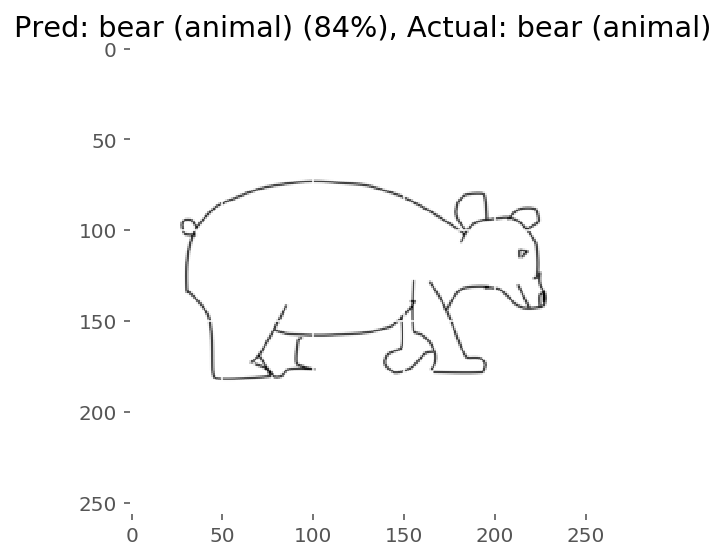

In [19]:
_ = make_predictions(model,
                     categories,
                     validation_filepaths, 
                     labels, 
                     random.randint(0,len(validation_filepaths) - 1))

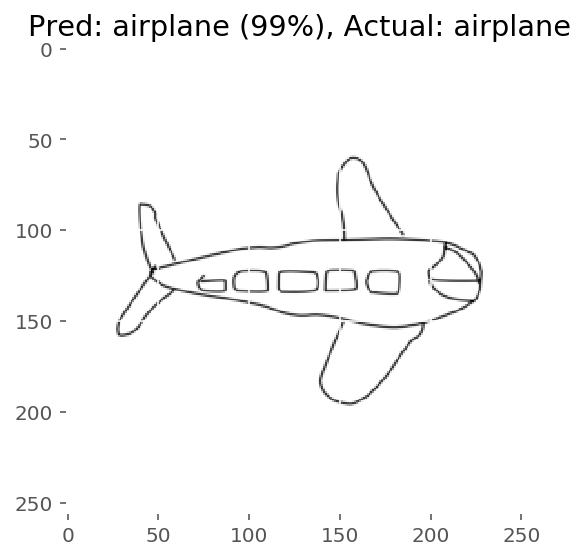

In [20]:
_ = make_predictions(model,
                     categories,
                     validation_filepaths, 
                     labels, 
                     0)

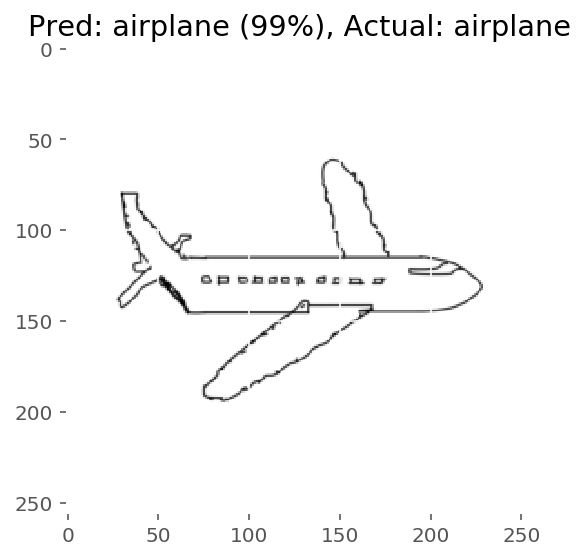

In [21]:
_ = make_predictions(model,
                     categories,
                     validation_filepaths, 
                     labels, 
                     10)

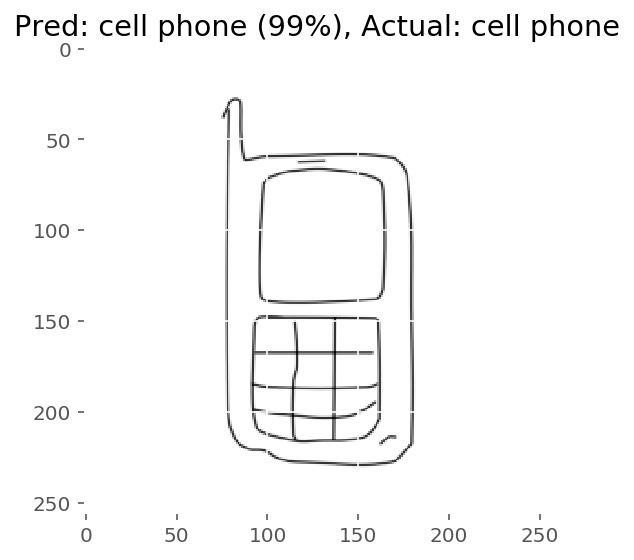

In [49]:
_ = make_predictions(model,
                     categories,
                     validation_filepaths, 
                     labels, 
                     801)

### Confusion matrix 

One way to evaluate the quality of your classifier (especially for multi-class) is visualising a confusion matrix. The diagonal elements represent the number of point for which the predicted label is equal to the true label, while the off-diagonal elements are those that are mislabeled by the classifier. The higher the diagonal values of the confusion matrix, the better the model is performing i.e. we should see a dark line diagonally along the plot. 

In [61]:
def plot_confusion_matrix(model, categories, filepaths, labels, 
                          target_dimension=256.0, normalize=False, cmap=plt.cm.Blues):
    from sklearn.metrics import confusion_matrix
    
    y_true = [] 
    y_pred = [] 
    
    category_2_idx = {category:idx for idx, category in enumerate(categories)}
    idx_2_category = {idx:category for idx, category in enumerate(categories)}
    
    for idx, filename in enumerate(filepaths): 
        img = plt.imread(filename) # load image 
    
        scale = 1.0 
        # resize if size doesn't match the target dimension (assuming image is square)
        if img.shape[0] != target_dimension:
            scale = target_dimension / img.shape[0]
            img = imresize(img, scale)
        
        img = img[:,:,0] # take the single channel 
        img = img.reshape(1, int(target_dimension), int(target_dimension), 1)
    
        probs = model.predict(img)[0]
        predicted_index = np.argmax(probs)        
        actual_index = category_2_idx[labels[idx]] 
        
        y_true.append(labels[idx])
        y_pred.append(idx_2_category[predicted_index])
        
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
        
    cnf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=categories)
    
    if normalize:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(12, 12))
    plt.imshow(cnf_matrix, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix')
    plt.colorbar()
    #tick_marks = np.arange(len(categories))
    #plt.xticks(tick_marks, categories, rotation=45)
    #plt.yticks(tick_marks, categories)
    #plt.tight_layout()
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()

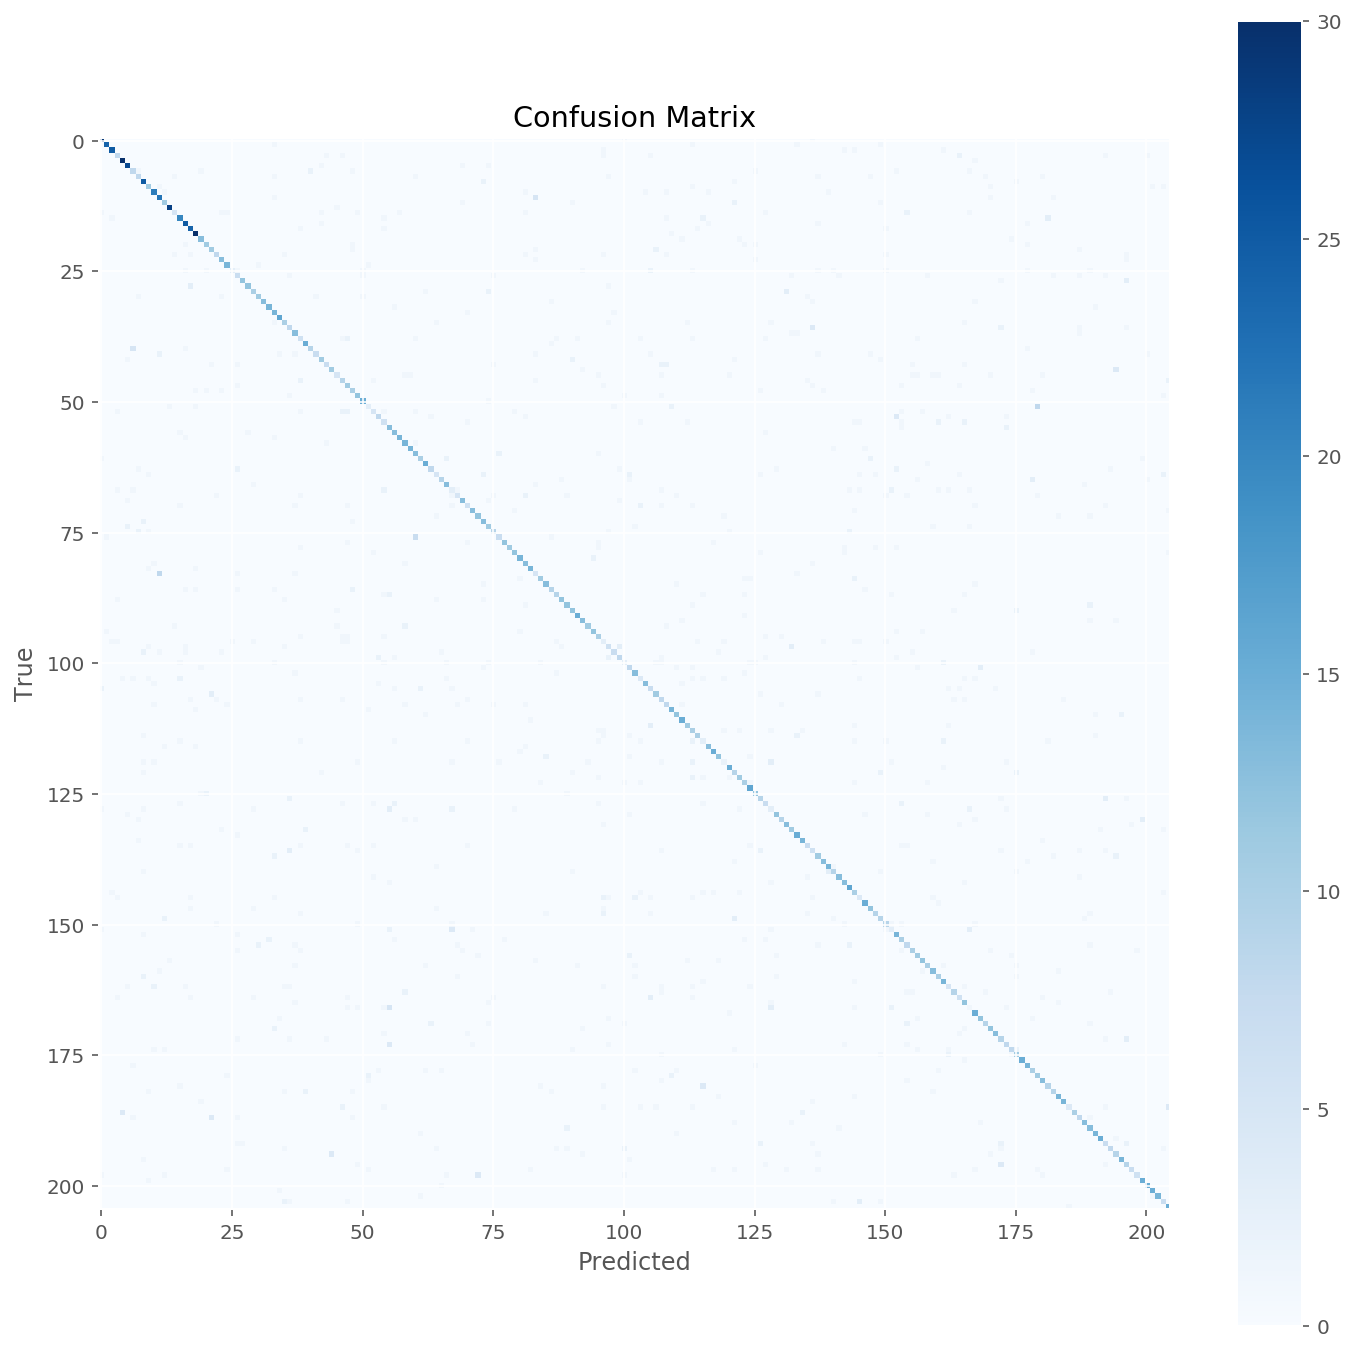

In [62]:
plot_confusion_matrix(model, 
                      categories, 
                      validation_filepaths, 
                      labels)

---

# Visualise the activations



In [31]:
def get_activations(model, categories, filepaths, labels, sample_idx, target_dimension=256.0):
    filename = filepaths[sample_idx]
    
    img = plt.imread(filename) # load image 
    
    scale = 1.0 
    # resize if size doesn't match the target dimension (assuming image is square)
    if img.shape[0] != target_dimension:
        scale = target_dimension / img.shape[0]
        img = imresize(img, scale)
        
    img = img[:,:,0] # take the single channel 
    img = img.reshape(1, int(target_dimension), int(target_dimension), 1)
    
    return model.predict(img)

In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 86, 86, 16)        800       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 43, 43, 16)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 43, 43, 32)        12832     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 21, 21, 64)        51264     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 10, 10, 64)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 10, 10, 64)        0         
__________

In [77]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 86, 86, 16)        800       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 43, 43, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 43, 43, 32)        12832     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 21, 21, 64)        51264     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 10, 10, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 10, 10, 64)        0         
__________

In [28]:
# extract the first 
layer_outputs = [layer.output for layer in model.layers[:10]]               
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) 

In [29]:
activation_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21_input (InputLayer) (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 86, 86, 16)        800       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 43, 43, 16)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 43, 43, 32)        12832     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 21, 21, 64)        51264     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 10, 10, 64)        0         
__________

## Visualise activations

In [50]:
activations = get_activations(activation_model,
                              categories,
                              validation_filepaths, 
                              labels, 
                              801)
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 86, 86, 16)


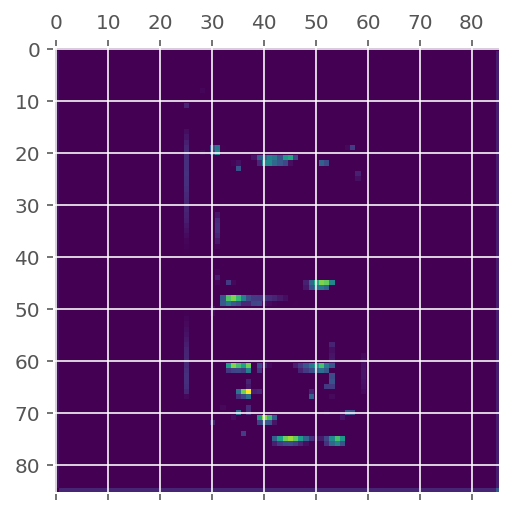

In [54]:
plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')

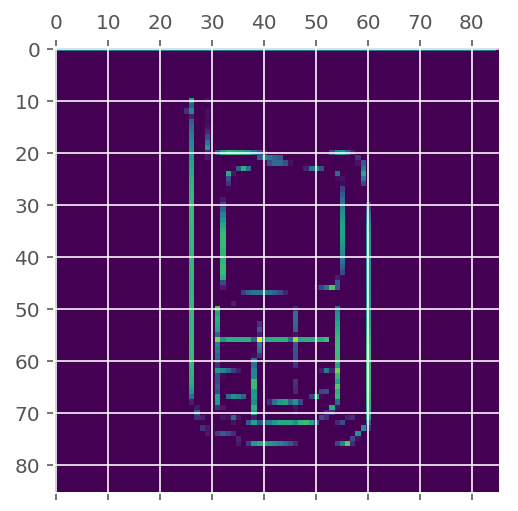

In [58]:
plt.matshow(first_layer_activation[0, :, :, 10], cmap='viridis')

## Visualise Feature Maps 

In [75]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    x += 0.5
    x = np.clip(x, 0, 1)

    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [138]:
def generate_pattern(layer_name, filter_index, size=256):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    grads = K.gradients(loss, model.input)[0]

    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    iterate = K.function([model.input], [loss, grads])

    input_img_data = np.random.random((1, size, size, 1)) * 20 + 128.

    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

    img = input_img_data[0]
    return deprocess_image(img)

In [139]:
def visualise_feature_maps_for_layer(model, layer_name):
    size = 256
    margin = 5

    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    for i in range(8):
        for j in range(8):
            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
            filter_img = filter_img

            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end,
                    vertical_start: vertical_end, :] = filter_img

    plt.figure(figsize=(20, 20))
    plt.imshow(results.resize(size, size), cmap='gray', 
           interpolation='nearest')

In [150]:
def visualise_feature_maps(model, layer_names=None):
    if layer_names is None:
        layer_names = []                                                          
        for layer in model.layers[:8]:
            if "conv" in layer.name:
                layer_names.append(layer.name)                                        

    for layer_name in layer_names:
        visualise_feature_maps_for_layer(model, layer_name)
        return

In [153]:
visualise_feature_maps(model, layer_names=['conv2d_21'])

ValueError: slice index 16 of dimension 3 out of bounds. for 'strided_slice_52' (op: 'StridedSlice') with input shapes: [?,86,86,16], [4], [4], [4] and with computed input tensors: input[1] = <0 0 0 16>, input[2] = <0 0 0 17>, input[3] = <1 1 1 1>.

---

In [168]:
def plot_feature_maps_for_layer(model, layer_name, size=256):
    filter_index = 0
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    
    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5) 
    iterate = K.function([model.input], [loss, grads])
    
    loss_value, grads_value = iterate([np.zeros((1, size, size, 1))])
    
    input_img_data = np.random.random((1, size, size, 1)) * 20 + 128.
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])

        input_img_data += grads_value * step 
        
    img = input_img_data[0]
    img = deprocess_image(img)

    plt.imshow(img.reshape(size, size), 
               cmap='gray', 
               interpolation='nearest')

(256, 256, 1)


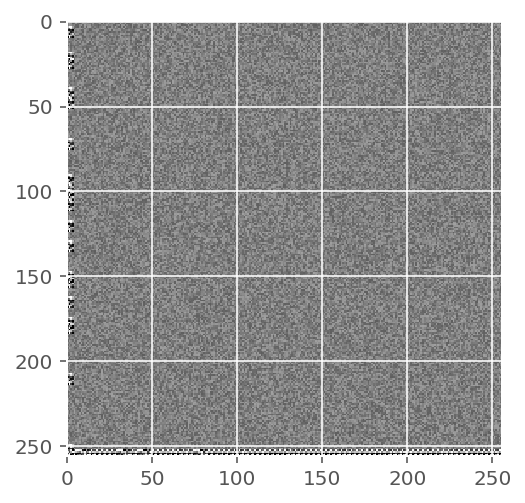

In [169]:
plot_feature_maps_for_layer(model, layer_name='conv2d_21')

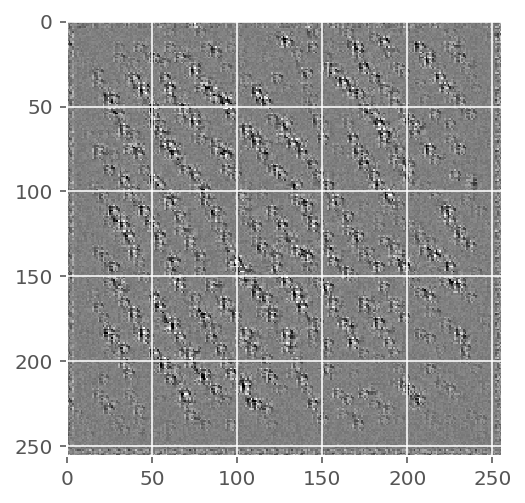

In [144]:
plot_feature_maps_for_layer(model, layer_name='conv2d_22')

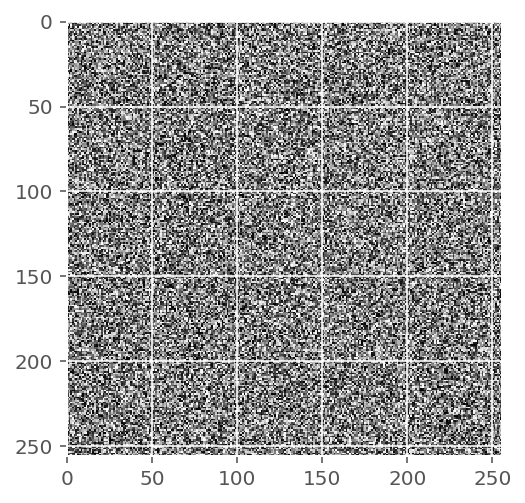

In [154]:
plot_feature_maps_for_layer(model, layer_name='conv2d_23')